# Implementation

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import librosa
import numpy as np
import soundfile as sf
from torch.autograd.variable import Variable
import IPython.display as ipd
import math
import librosa.display
import json
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import librosa
import numpy as np
import soundfile as sf
from PIL import Image as im
import gc
import cv2
from tensorflow.keras import layers, models, losses, Model

## Utility functions

In [ ]:
def preprocess(givenPath, json_path):
    convertedData = {
        "labels": [],
        "coefficients": []
        }
    for i, (folderPath, _ , songNames) in enumerate(os.walk(givenPath)):
        for songfile in songNames:
            song, samplingRate = librosa.load(os.path.join(folderPath, songfile), duration=29)
            j=0
            while j<10:
                # Here we are spliting the data into equal slices to increase the total data size as these slices will be used for training the model. 
                start_sample = 63945 * j
                end_sample = start_sample + 63945
                coefficients = librosa.feature.coefficients(y=song[start_sample:end_sample], sr=samplingRate, n_coefficients=13)
                coefficients = coefficients.T
                convertedData["labels"].append(i-1)
                convertedData["coefficients"].append(coefficients.tolist())
                j=j+1    
    with open(json_path, 'w') as f:
        json.dump(convertedData, f)
    f.close()

In [ ]:
def fetchData(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()
    coefficients = np.array(data["coefficients"])
    labels = np.array(data["labels"])
    return coefficients, labels

In [ ]:
def makeDataSet(inputData, labels, splitRatio):
    inputData_train, inputData_val, labels_train, labels_val = train_test_split(inputData, labels, test_size=splitRatio)
    inputData_train, inputData_test, labels_train, labels_test = train_test_split(inputData_train, labels_train, test_size=splitRatio)
    inputData_train = inputData_train[..., np.newaxis]
    inputData_val = inputData_val[..., np.newaxis]
    inputData_test = inputData_test[..., np.newaxis]
    return inputData_train, inputData_val, inputData_test, labels_train, labels_val, labels_test

In [ ]:
def makeModel(dataShape):
    # the main model is defined here
    model = tf.keras.models.Sequential([        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=dataShape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])
    return model

In [ ]:
def checkMyModel(model, X, y, XID):
    allGenres = { 0 : "blues", 1 : "classical",2 : "country",3 : "disco",4 : "hiphop",5 : "jazz",6 : "metal",7 : "pop",8 : "reggae",9 : "rock"}
    predictedGenre = model.predict(X)
    indexGenre = np.argmax(predictedGenre[XID])    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(allGenres[indexGenre], allGenres[y[XID]]))

In [ ]:


def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()



## Base CNN 

### Data Loading, Preprocessing

In [ ]:
JSON_PATH='dataOG.json'
SOURCE_PATH = '/content/drive/MyDrive/Deep_Learning_Project/Data/genres_original/'

### Train, Validation and Test datasets

Main body to call the functions and train the model on the original GTZAN dataset

(9990, 125, 13)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 62, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
200/200 [==============================] - 16s 72ms/step - loss: 1.6030 - acc: 0.4417 - val_loss: 1.7612 - val_acc: 0.4089
Epoch 2/30
200/200 [==============================] - 16s 79ms/step - loss: 1.1952 - acc: 0.5739 - val_loss: 1.2012 - val_acc: 0.5691
Epoch 3/30
200/200 [==============================] - 16s 78ms/step - loss: 1.0080 - acc: 0.6379 - val_loss: 1.0632 - val_acc: 0.6271
Epoch 4/30
200/200 [==============================] - 14s 71ms/step - loss: 0.9061 - acc: 0.6801 - val_loss: 1.1147 - val_acc: 0.6106
Epoch 5/30
200/200 [==============================] - 14s 71ms/step - loss: 0.8015 - acc: 0.7172 - val_loss: 1.0808 - val_acc: 0.6371
Epoch 6/30
200/200 [==============================] - 14s 72ms/step - loss: 0.7427 - acc: 0.7367 - val_loss: 0.9956 - val_acc: 0.6647
Epoch 7/30
200/200 [==============================] - 14s 72ms/step - loss: 0.6798 - acc: 0.7624 - val_loss: 0.7957 - val_acc: 0.7362
Epoch 8/30
200/200 [==============================] - 14s 72ms

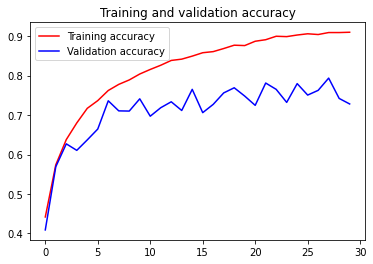

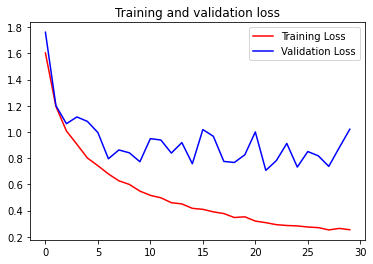

50/50 [==============================] - 1s 17ms/step

---Now testing the model for one audio file---
The model predicts: hiphop, and ground truth is: hiphop.



In [ ]:
preprocess(SOURCE_PATH, json_path=JSON_PATH)
inputs, targets = fetchData(json_path=JSON_PATH)
Xtrain, Xval, Xtest, ytrain, yval, ytest = makeDataSet(inputs, targets, 0.2)
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = makeModel(input_shape)
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics = ['acc'] )
model.summary()

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30,batch_size=32)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

checkMyModel(model, Xtest, ytest, 24)

In [ ]:
test_results={}
test_results = model.evaluate(
    Xtest, ytest, verbose=0)

print('Test accuracy: {:.2f}%'.format(test_results[1]*100))


Test accuracy: 73.48%


## Experiment with Augmented Data

### Preprocess Data 

Augmenting the data


In [ ]:
def add_white_noise(song, noiseFactor):
    noise = np.random.normal(0, song.std(), song.size)
    augmentedAudio = song + noise * noiseFactor
    return augmentedAudio

In [ ]:
def pitch_scale(song, samplingRate, scaleByTones):
    return librosa.effects.pitch_shift(song, samplingRate, scaleByTones)

In [ ]:
def random_gain(song, minimum=5, maximum=5.5):
    gainBy = random.uniform(minimum, maximum)
    augmented_song = song * gainBy
    return augmented_song

In [ ]:
def invert_polarity(song):
    return song * -1

In [ ]:
for i, (dirpath, _ , songNames) in enumerate(os.walk("/content/drive/MyDrive/Deep_Learning_Project/Data/genres_original")):
        if i!=0:
            for songfile in songNames:
                song, samplingRate = librosa.load(os.path.join(dirpath, songfile), duration=29)
                mypath=os.path.join(dirpath,songfile)
                augmented_signal_invert = invert_polarity(song)
                augmented_signal_random = random_gain(song)
                augmented_signal_white = add_white_noise(song, 0.1)
                augmented_signal_pitch = pitch_scale(song, samplingRate, 2)
                t1 = os.path.splitext(mypath)[0] + "auginvert.wav"
                t2 = os.path.splitext(mypath)[0] + "augrandom.wav"
                t3 = os.path.splitext(mypath)[0] + "augwhite.wav"
                t4 = os.path.splitext(mypath)[0] + "augpitch.wav"
                print(t1)
                print(t2)
                print(t3)
                print(t4)
                sf.write(t1, augmented_signal_invert, samplingRate)
                sf.write(t2, augmented_signal_random, samplingRate)
                sf.write(t3, augmented_signal_white, samplingRate)
                sf.write(t4, augmented_signal_pitch, samplingRate)
                print(mypath)                

Specifying the path for training, validation and testing data.

In [ ]:
JSON_PATH='data.json'
SOURCE_PATH = '/content/drive/MyDrive/Deep Learning Project/train'
TESTING_PATH='/content/drive/MyDrive/Deep_Learning_Project/Data/genres_original/test'
JSON_TEST_PATH='test_data.json'
VALIDATION_PATH='/content/drive/MyDrive/Deep_Learning_Project/Data/genres_original/val'
JSON_VALIDATION_PATH='validation_data.json'


Creating the JSON file for Training data

In [ ]:
preprocess(SOURCE_PATH,JSON_PATH)

Creating the JSON file for Validation data

In [ ]:
preprocess(VALIDATION_PATH, JSON_VALIDATION_PATH)

Creating the JSON file for the Testing data

In [ ]:
preprocess(TESTING_PATH, JSON_TEST_PATH)

Loading and reshaping the test-inputs

In [ ]:
test_inputs, test_targets = fetchData(json_path=TESTING_PATH)
inputs_test = test_inputs[..., np.newaxis]
len(inputs_test), len(test_targets)

Loading and reshaping the validation-inputs

In [ ]:
validation_inputs, validation_targets = fetchData(json_path=VALIDATION_PATH)
inputs_val = validation_inputs[..., np.newaxis]
len(inputs_val), len(validation_targets)

Loading and reshaping the training-inputs

In [ ]:
inputs, targets = fetchData(json_path=JSON_PATH)
inputs_train = inputs[..., np.newaxis]
len(inputs_train), len(targets)

In [ ]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = inputs_train, inputs_val,inputs_test,targets,validation_targets,test_targets

### Training the model with augmented data

In [ ]:
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = makeModel(input_shape)
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=32 )

(34950, 125, 13)
(34950,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
699/699 [==============================] - 12s 6ms/step - loss: 1.3885 - acc: 0.4173 - val_loss: 1.0507 - val_acc: 0.5268
Epoch 2/30
699/699 [==============================] - 4s 5ms/step - loss: 0.9397 - acc: 0.5727 - val_loss: 0.9186 - val_acc: 0.5858
Epoch 3/30
699/699 [==============================] - 4s 5ms/step - loss: 0.7736 - acc: 0.6317 - val_loss: 0.8265 - val_acc: 0.6286
Epoch 4/30
699/699 [==============================] - 4s 5ms/step - loss: 0.6795 - acc: 0.6640 - val_loss: 0.6766 - val_acc: 0.6763
Epoch 5/30
699/699 [==============================] - 4s 5ms/step - loss: 0.6026 - acc: 0.6901 - val_loss: 0.5776 - val_acc: 0.7146
Epoch 6/30
699/699 [==============================] - 4s 5ms/step - loss: 0.5349 - acc: 0.7144 - val_loss: 0.4846 - val_acc: 0.7329
Epoch 7/30
699/699 [==============================] - 4s 5ms/step - loss: 0.4931 - acc: 0.7279 - val_loss: 0.7753 - val_acc: 0.6439
Epoch 8/30
699/699 [==============================] - 4s 5ms/step - loss: 0

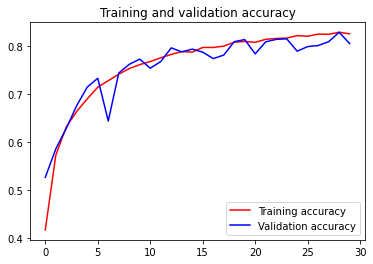

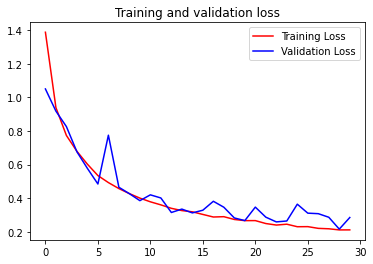

175/175 [==============================] - 0s 2ms/step

---Now testing the model for one audio file---
The model predicts: metal, and ground truth is: metal.



In [ ]:
plot_performance(history)
checkMyModel(model, Xtest, ytest, 24)

### Testing augmented data

In [ ]:
testing={}
testing = model.evaluate( Xtest, ytest, verbose=0)
print('Test accuracy: {:.2f}%'.format(testing[1]*100))

Test accuracy: 74.92%


## GRU Models

### Network Architecture

In [ ]:
gru_model=keras.Sequential()
gru_model.add(layers.GRU(64,input_shape=(125,13)))
gru_model.add(layers.BatchNormalization())
gru_model.add(layers.Dense(64))
gru_model.add(layers.BatchNormalization())
gru_model.add(layers.Dense(10))
print(gru_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                15168     
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 20,490
Trainable params: 20,234
Non-trai

### Train

In [ ]:
inputs,targets=fetchData(json_path=JSON_PATH)
Xtrain,Xval,Xtest,ytrain,yval,ytest=makeDataSet(inputs,targets,0.2)
input_shape=(Xtrain.shape[1],Xtrain.shape[2], 1)

(9990, 125, 13)


In [ ]:
gru_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"],
)
gru_model.summary()

In [ ]:
history_gru= gru_model.fit(Xtrain, ytrain,validation_data=(Xval, yval),epochs=100,batch_size=64)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                15168     
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 20,490
Trainable params: 20,234
Non-trai

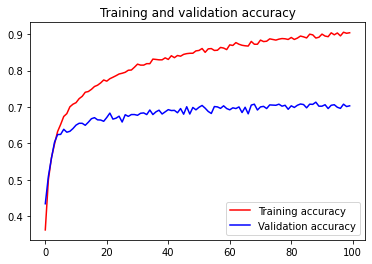

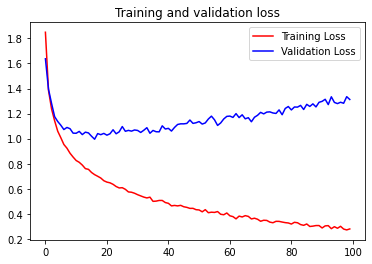

50/50 [==============================] - 1s 4ms/step

---Now testing the model for one audio file---
The model predicts: metal, and ground truth is: metal.



In [ ]:
plot_performance(history_gru)

### Test

In [ ]:
test_results={}
test_results = model.evaluate(Xtest, ytest, verbose=0)
print('Test accuracy: {:.2f}%'.format(test_results[1]*100))

Test accuracy: 68.92%


## Transfer Learning

In [ ]:
sr=22050
samples=29*sr
slices=3
sample_per_slice=int(samples/slices)
json_path='data_half.json'
source='Data/genres_original/'
img_size=224

### Create audio files with three slices each and store them in a json file for later use

In [ ]:
preprocess_data(source,json_path)

### Load the input files in a numpy array and the targets

In [ ]:
inputs,targets=fetchData(json_path=json_path)

(2997, 417, 13)


### Resize the images to 224x224 dimension for later use

In [ ]:
for i in tqdm(range(inputs.shape[0])):
    plt.figure(figsize=(15, 8))
    librosa.display.specshow(image_data[i], x_axis="time", sr=sr)
    plt.colorbar(format="%+2.f")
    plt.savefig('mfcc_half/'+str(i)+'.png', format="png")
    plt.close()
    if(i%100==99):
        gc.collect()

### Load image data for train, test and validation

In [ ]:
def getData(data_dir):
    data=[] 
    path=data_dir
    for img in os.listdir(path):
        img_arr=cv2.imread(os.path.join(path,img))[...,::-1]
        resized_arr=cv2.resize(img_arr,(img_size,img_size))
        data.append(resized_arr)
        print(img)
    return np.array(data)

In [ ]:
images=getData('mfcc_half')

1997.png
1998.png
1999.png
2000.png
2001.png
2002.png
2003.png
2004.png
2005.png
2006.png
2007.png
2008.png
2009.png
2010.png
2011.png
2012.png
2013.png
2014.png
2015.png
2016.png
2017.png
2018.png
2019.png
2020.png
2021.png
2022.png
2023.png
2024.png
2025.png
2026.png
2027.png
2028.png
2029.png
2030.png
2031.png
2032.png
2033.png
2034.png
2035.png
2036.png
2037.png
2038.png
2039.png
2040.png
2041.png
2042.png
2043.png
2044.png
2045.png
2046.png
2047.png
2048.png
2049.png
2050.png
2051.png
2052.png
2053.png
2054.png
2055.png
2056.png
2057.png
2058.png
2059.png
2060.png
2061.png
2062.png
2063.png
2064.png
2065.png
2066.png
2067.png
2068.png
2069.png
2070.png
2071.png
2072.png
2073.png
2074.png
2075.png
2076.png
2077.png
2078.png
2079.png
2080.png
2081.png
2082.png
2083.png
2084.png
2085.png
2086.png
2087.png
2088.png
2089.png
2090.png
2091.png
2092.png
2093.png
2094.png
2095.png
2096.png
2097.png
2098.png
2099.png
2100.png
2101.png
2102.png
2103.png
2104.png
2105.png
2106.png
2107.png
2

In [ ]:
print(images.shape)

(2997, 256, 256, 3)


In [ ]:
Xtrain,Xval,Xtest,ytrain,yval,ytest=makeDataSet(images,targets,0.2)

### Train with ResNet50

Training hyperparameters

In [ ]:
dropout=0.5
dense_layer=128 
reg_penalty=0.0005
learning=0.00001
epochs=500
batch=64

Train

In [ ]:
base_model=tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in base_model.layers:
  layer.trainable=False
x=layers.Flatten()(base_model.output)
x=layers.Dropout(dropout)(x)
x=layers.Dense(dense_layer,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=reg_penalty),kernel_initializer=tf.keras.initializers.HeUniform(seed=None))(x)
x=layers.Dropout(dropout)(x)
predictions=layers.Dense(10,activation='softmax')(x)
res_model=Model(inputs=base_model.input,outputs=predictions)
res_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history_res=res_model.fit(Xtrain,ytrain,batch_size=batch,epochs=epochs,validation_data=(Xval,yval))

Epoch 1/500
30/30 [==============================] - 12s 296ms/step - loss: 27.7287 - accuracy: 0.1116 - val_loss: 25.7203 - val_accuracy: 0.1800
Epoch 2/500
30/30 [==============================] - 8s 270ms/step - loss: 25.3508 - accuracy: 0.1419 - val_loss: 24.4839 - val_accuracy: 0.2100
Epoch 3/500
30/30 [==============================] - 8s 277ms/step - loss: 23.9485 - accuracy: 0.1534 - val_loss: 23.2576 - val_accuracy: 0.2250
Epoch 4/500
30/30 [==============================] - 9s 286ms/step - loss: 22.6772 - accuracy: 0.1779 - val_loss: 22.0347 - val_accuracy: 0.2617
Epoch 5/500
30/30 [==============================] - 9s 291ms/step - loss: 21.5175 - accuracy: 0.1753 - val_loss: 20.8777 - val_accuracy: 0.2683
Epoch 6/500
30/30 [==============================] - 9s 288ms/step - loss: 20.3693 - accuracy: 0.1695 - val_loss: 19.7656 - val_accuracy: 0.2600
Epoch 7/500
30/30 [==============================] - 8s 280ms/step - loss: 19.2564 - accuracy: 0.1894 - val_loss: 18.6898 - val_a

#### Visualize accuracies

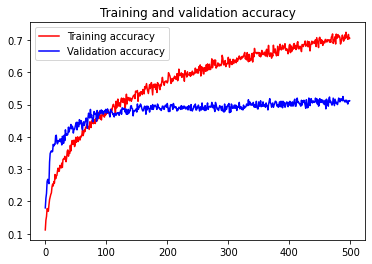

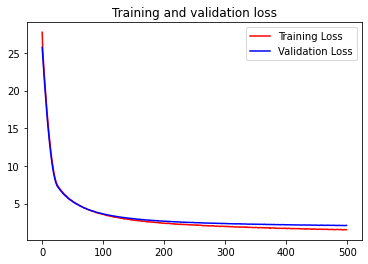

In [ ]:
plot_performance(history_res)

In [ ]:
test_results={}
test_results=res_model.evaluate(Xtest,ytest,verbose=0)
print('Test accuracy: {:.2f}%'.format(test_results[1]*100))

Test accuracy: 52.08%
